In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import datareader.cleaner.lemas as cl
import simnet.similarity
import simnet.variety
from diffusion.simple_diff import get_diffusion_diff
from model_selection.stepwise import BackwardStepwise

from tqdm import tqdm

In [2]:
## Get the attribute data for agencies
INDEX_COL = "ORI9"
df, cat_cols, con_cols = cl.lemas_df_cols("Imputed_Lemas.csv")
df = df[~(df['ORI9']==' ')]

all_nodes = df[INDEX_COL]

## Define the similarity metric
cosine_sim_8 = simnet.similarity.CosineSimilarity(0.8)

## Get the entropy-filtered columns
cat_col_variety_full = {col: v
                   for col in cat_cols if (v:=simnet.variety.get_discrete_variety_score(df[col]))}
variety_p75 = np.percentile(list(cat_col_variety_full.values()), 50)
cat_col_variety_75 = [col for col, v in cat_col_variety_full.items() if v > variety_p75]
cols_to_include = cat_col_variety_75 + ["log_pop", "log_budget"]


In [3]:
df.set_index("ORI9")

,Unnamed: 0,LEAR_ID,AGENCYNAME,CITY,ZIPCODE,STATE,COUNTY,FIPS,POPSERVED,POPGROUP,...,ISSU_ADDR_SCH,ISSU_ADDR_SWAT,ISSU_ADDR_TERROR,ISSU_ADDR_VIC,FINALWGT,NEW_TOT_HIRES,NEW_TOT_SEP,FINALWGT_NTH_NTS,log_pop,log_budget
ORI9,,,,,,,,,,,,,,,,,,,,,
CA0570100,0,635592,DAVIS POLICE DEPARTMENT,DAVIS,95618,CA,YOLO,6113,68111,5,...,3,2,3,2,7.185185,5.703704,3.629630,7.533981,0.660713,0.783248
NJ0091200,1,645110,WEST NEW YORK POLICE,WEST NEW YORK,7093,NJ,HUDSON,34017,53343,5,...,3,2,2,3,1.131206,31.629433,26.578014,1.183673,0.546056,0.674355
WV0310400,2,631270,WESTOVER POLICE DEPARTMENT,WESTOVER,26501,WV,MONONGALIA,54061,4243,8,...,5,5,5,5,7.304746,1.027363,0.634328,7.607534,-0.641567,-0.694089
WI0570200,3,631316,BARABOO POLICE DEPARTMENT,BARABOO,53913,WI,SAUK,55111,12173,7,...,1,2,3,3,6.913793,3.047414,2.344828,7.225225,-0.147114,-0.001664
WI0137400,4,631684,OREGON POLICE DEPARTMENT,OREGON,53575,WI,DANE,55025,3334,8,...,2,5,5,3,6.978166,1.711790,1.235808,7.347126,-0.754676,-0.207605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NV0020100,2779,645361,LAS VEGAS METRO POLICE DEPARTMENT,LAS VEGAS,89106,NV,CLARK,32003,1592178,1,...,4,1,1,2,1.131206,354.000000,216.000000,1.183673,2.139320,2.334349
CA0190000,2780,635749,LOS ANGELES COUNTY SHERIFF'S DEPARTMENT,MONTEREY PARK,91754,CA,LOS ANGELES,6037,10137915,1,...,2,1,1,2,1.321033,460.000000,1694.000000,1.415020,3.007789,3.131008
ILCPD0000,2781,638583,CHICAGO POLICE DEPARTMENT,CHICAGO,60653,IL,COOK,17031,2704958,1,...,2,1,1,2,1.131206,595.000000,506.000000,1.183673,2.387959,2.763773


In [4]:
## Get the State dynamic
nibrs_df = pd.read_parquet("DATA/map_plot.pq")

## Filter those that are within the attribute data
dynamic = nibrs_df[nibrs_df["ORI"].isin(all_nodes)].assign(y = nibrs_df["NUMBER OF MONTHS REPORTED"]>0) \
    .pivot_table(index="ORI", columns="year", values="y", aggfunc='first').fillna(False)
dynamic

year,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
ORI,,,,,,,,,,,,,,,,,,,,,
AK0010100,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AK0010300,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
AK0011600,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
AK0015600,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
AL0010000,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WY0150100,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,True
WY0190000,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
WY0210000,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,True


In [5]:
common_agencies = sorted(set(dynamic.index) & set(df["ORI9"]))
df= df.set_index("ORI9").loc[common_agencies]

In [6]:
list(df.index) == list(dynamic.index)

True

In [7]:
cols_to_include.index('ISSU_ADDR_REPOFF')

77

In [7]:
removal_dict:dict[str, int] = {}
logging:list[dict[str, int]] = []
cols_to_include_for_removal = cols_to_include.copy()
while (n:=len(cols_to_include_for_removal) )>=10:
    diff_dict = dict()
    for cat_col_i, col_name in enumerate(cols_to_include_for_removal):

        col_to_try = cols_to_include_for_removal[:cat_col_i] + cols_to_include_for_removal[cat_col_i+1:]
        sn = simnet.similarity.SimilarityNetwork(
            df,
            cosine_sim_8,
            col_to_try
        )
        W = sn.fit_transform().toarray()


        # ## Any way to improve performance?
        # G = sn.network.subgraph(dynamic.index)

        # W = np.matrix(nx.adjacency_matrix(G, dynamic.index).toarray())
        diff = get_diffusion_diff(
            np.matrix(W),
            dynamic.to_numpy(dtype=int),
            0.5
        )

        diff_dict[col_name] = diff

    rank_by_se = dict(sorted(diff_dict.items(), key=lambda item: item[1]))
    worst_col =  list(rank_by_se.keys())[0] ## Remove this columns yields the best performance improve
    logging.append(rank_by_se)
    removal_dict[worst_col] = rank_by_se[worst_col]
    print(n, worst_col, rank_by_se[worst_col], sep='\t')
    cols_to_include_for_removal.remove(worst_col)

131
131	AGENCYTYPE	3051
130
130	EQ_AUTH_EXP	3035
129
129	ISSU_ADDR_REPOFF	3002
128
128	POL_MAXHRS	3000
127
127	TECH_IFC_DRVREC	2948
126
126	TECH_WEB_REPORT	2966
125
125	log_pop	2944
124
124	EQ_BCK_CASH	2931
123
123	ISSU_ADDR_VIC	2929
122
122	PERS_CULTURE	2938
121
121	CP_SURV_CRPROB	2923
120
120	ISSU_ADDR_HUMTRF	2933
119
119	ISSU_ADDR_MISCHD	2895
118
118	TECH_IFC_ADDHIS	2853
117
117	TECH_FILE_COMPL	2852
116
116	EQ_VEH_ARMOR	2869
115
115	POL_INV_ICD	2864
114
114	CP_SURV_PERFORM	2834
113
113	TECH_FILE_PRTORD	2852
112
112	TECH_WEB_STAT	2806
111
111	TECH_WEB_COMPL	2810
110
110	POL_VEHPURS	2796
109
109	CP_SURV_RESOURCE	2790
108
108	CP_CPACAD	2802
107
107	EQ_DOC_NECK	2786
106
106	TECH_SM_TWITTER	2777
105
105	EQ_AUTH_CHEM	2784
104
104	TECH_TYP_LPR	2805
103
103	POL_TERROR	2811
102
102	ISSU_ADDR_CRMANL	2814
101
101	TECH_WEB_STOP	2788
100
100	TECH_FILE_INFORM	2815
99
99	CP_SURV_POLICY	2810
98
98	EQ_VEH_MTRCYCL	2811
97
97	TECH_IFC_PRTORD	2801
96
96	ISSU_ADDR_SWAT	2804
95
95	ISSU_ADDR_GUNS	2781
94


In [32]:
import pickle

with open("back_7.pkl", 'wb') as f:
    pickle.dump(logging_7, f)

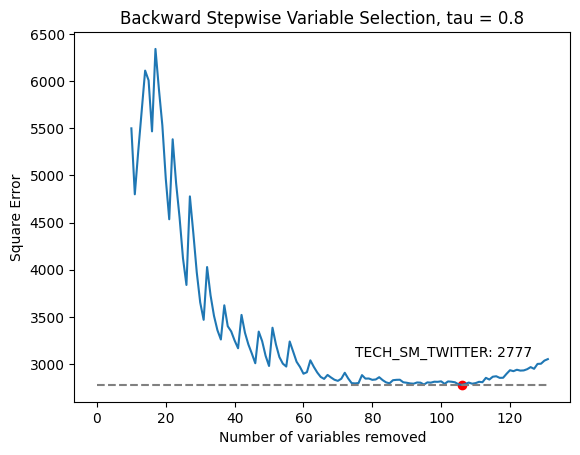

In [27]:
from matplotlib import pyplot as plt


plt.plot([131-n for n in range(len(removal_dict))], removal_dict.values())
min_value_col, min_value = sorted(removal_dict.items(), key=lambda item: item[1])[0]
plt.hlines(y = min_value, xmin=0, xmax=131, linestyles='--', colors='grey')
plt.annotate(f"{min_value_col}: {min_value}", (75, min_value+300))
plt.scatter(x = 106, y = min_value, c='r')
plt.xlabel("Number of variables removed")
plt.ylabel("Square Error")
plt.title("Backward Stepwise Variable Selection, tau = 0.8");

In [28]:

cosine_sim_7 = simnet.similarity.CosineSimilarity(0.7)

removal_dict_7:dict[str, int] = {}
logging_7:list[dict[str, int]] = []
cols_to_include_for_removal = cols_to_include.copy()

while (n:=len(cols_to_include_for_removal) )>=10:
    diff_dict = dict()
    for cat_col_i, col_name in enumerate(cols_to_include_for_removal):

        col_to_try = cols_to_include_for_removal[:cat_col_i] + cols_to_include_for_removal[cat_col_i+1:]
        sn = simnet.similarity.SimilarityNetwork(
            df,
            cosine_sim_7,
            col_to_try
        )
        W = sn.fit_transform().toarray()
        # G = sn.network.subgraph(dynamic.index)

        # W = np.matrix(nx.adjacency_matrix(G, dynamic.index).toarray())
        diff = get_diffusion_diff(
            np.matrix(W),
            dynamic.to_numpy(dtype=int),
            0.5
        )

        diff_dict[col_name] = diff

    rank_by_se = dict(sorted(diff_dict.items(), key=lambda item: item[1]))
    worst_col =  list(rank_by_se.keys())[0] ## Remove this columns yields the best performance improve
    logging_7.append(rank_by_se)
    removal_dict_7[worst_col] = rank_by_se[worst_col]
    print(n, worst_col, rank_by_se[worst_col], sep='\t')
    cols_to_include_for_removal.remove(worst_col)

131	EQ_REV_ON_PRIM	5316
130	TECH_FILE_PRTORD	5234
129	TECH_IFC_GISMAP	4996
128	TECH_TYP_TRACE	5031
127	CP_PSP_LEA	5084
126	POL_HOMELESS	4977
125	TECH_COMP_CRMANL	4780
124	EQ_SEATBELT	4889
123	POL_INV_INJRY	4821
122	EQ_SEC_FULLAUTO	4778
121	TECH_FILE_VIDEO	4809
120	ISSU_ADDR_DUI	4799
119	PERS_COLBAR_NON	4778
118	CP_SURV_POLICY	4778
117	TECH_ILES_INTEL	4794
116	EQ_AUTH_NECK	4724
115	log_budget	4718
114	TECH_TYP_TIREDFL	4720
113	EQ_SEMI_ON_BACK	4632
112	TECH_COMP_SNA	4604
111	ISSU_ADDR_HUMTRF	4691
110	EQ_BCK_IND	4695
109	EQ_SEC_SEMIAUTO	4720
108	TECH_WEB_STOP	4724
107	CP_SURV_TRAINING	4597
106	EQ_SEC_MANUAL	4690
105	EQ_AUTH_BLNT	4545
104	PERS_CREDHIS	4561
103	EQ_AUTH_EXP	4581
102	ISSU_ADDR_CYBER	4579
101	TECH_IFC_WARR	4554
100	TECH_WEB_COMPL	4520
99	CP_MISSION	4513
98	EQ_SEC_SHOTGUN	4539
97	EQ_BDYARM	4506
96	TECH_IFC_PRTORD	4513
95	EQ_DOC_EXP	4368
94	ISSU_ADDR_MISCHD	4432
93	EQ_AUTH_CED	4500
92	TECH_FILE_INFORM	4519
91	ISSU_ADDR_DRUG_ED	4454
90	CP_SURV_PERFORM	4465
89	POL_VEHPURS	4443
88	

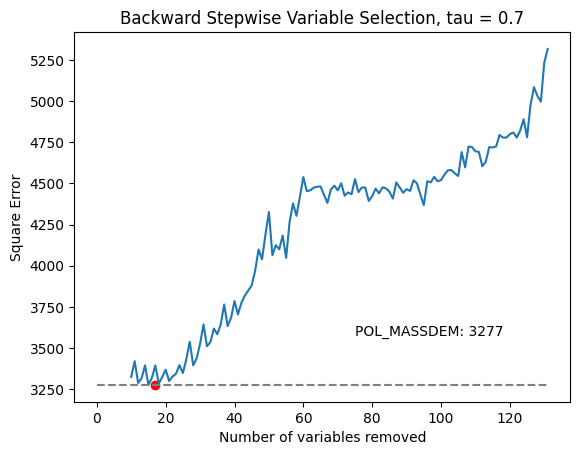

In [30]:
from matplotlib import pyplot as plt


plt.plot([131-n for n in range(len(removal_dict_7))], removal_dict_7.values())
min_value_col, min_value = sorted(removal_dict_7.items(), key=lambda item: item[1])[0]
plt.hlines(y = min_value, xmin=0, xmax=131, linestyles='--', colors='grey')
plt.annotate(f"{min_value_col}: {min_value}", (75, min_value+300))
plt.scatter(x = 17, y = min_value, c='r')
plt.xlabel("Number of variables removed")
plt.ylabel("Square Error")
plt.title("Backward Stepwise Variable Selection, tau = 0.7");

In [46]:
## try GA

## Try using genetic algorithm

def fitness_function(ga_instance, solution, sol_index):

    # solution is a n = 131 vector, indicating include or not

    col_to_try = [cols_to_include[i] for i in range(len(solution)) if solution[i] == 1]
    sn = simnet.similarity.SimilarityNetwork(
        df,
        cosine_sim_8,
        col_to_try
    )
    W = sn.fit_transform().toarray()
    # G = sn.network.subgraph(dynamic.index)

    # W = np.matrix(nx.adjacency_matrix(G, dynamic.index).toarray())
    diff = get_diffusion_diff(
        np.matrix(W),
        dynamic.to_numpy(dtype=int),
        0.5
    )
    return 1/diff

In [59]:
import pygad

ga_instance_8 = pygad.GA(
    num_generations=100,
    num_parents_mating=4,
    fitness_func=fitness_function,
    sol_per_pop = 64,
    num_genes=len(cols_to_include),
    mutation_percent_genes = 10,
    gene_space=[0,1],
    gene_type=int
)

In [60]:
ga_instance_8.run()

In [61]:
solution, solution_fitness, solution_idx = ga_instance_8.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))


Parameters of the best solution : [0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0
 1 1 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0
 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0
 1 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0]
Fitness value of the best solution = 0.0003562522265764161


In [62]:
1/fitness_function(0,solution, 0)

2807.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


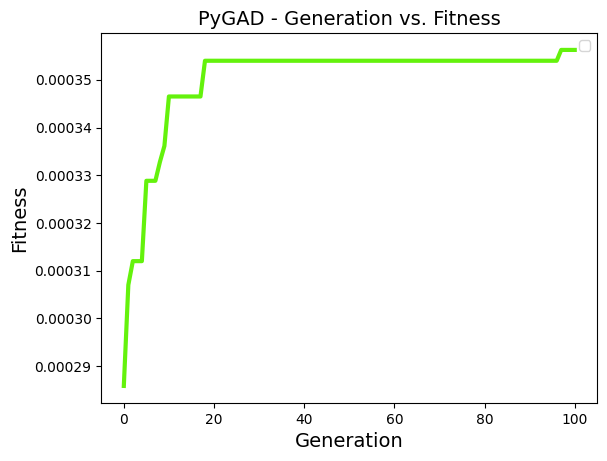

In [64]:
ga_instance_8.plot_fitness();

In [70]:
## load backward stepwise solution as initial populations
import pickle

with open("back_8.pkl", 'rb') as f:
    logging_8 = pickle.load(f)

In [74]:
cols_to_include_for_removal = cols_to_include.copy()
solution_set = [1]*131
populations = []
for diff_dict in logging_8:
    rank_by_se = dict(sorted(diff_dict.items(), key=lambda item: item[1]))
    worst_col =  list(rank_by_se.keys())[0] ## Add this columns yields the best performance improve
    to_remove_index = cols_to_include.index(worst_col)
    solution_set[to_remove_index] = 0
    populations.append(solution_set.copy())

# get 10 min


In [99]:
init_population = np.array(populations[:131-60])
print(init_population.shape)

ga_instance_from_stepwise = pygad.GA(
    num_generations=60,
    num_parents_mating=4,
    fitness_func=fitness_function,
    initial_population=init_population,
    mutation_percent_genes = 10,
    gene_space=[0,1],
    gene_type=int
)

(71, 131)


In [100]:
ga_instance_from_stepwise.run()

In [102]:

solution, solution_fitness, solution_idx = ga_instance_from_stepwise.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=int(1/solution_fitness)))


Parameters of the best solution : [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 1
 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0
 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1]
Fitness value of the best solution = 2777


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


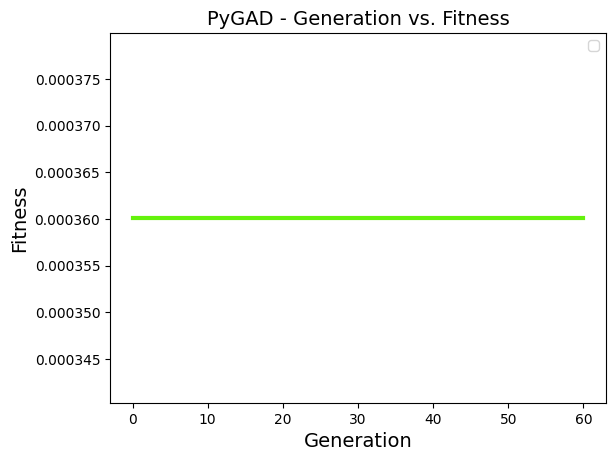

In [103]:
ga_instance_from_stepwise.plot_fitness();

In [104]:
with open("ga_step.pk", 'wb') as f:
    pickle.dump(ga_instance_from_stepwise, f)

In [ ]:

appending_dict:dict[str, int] = {}
cols_to_include_for_appending = cols_to_include.copy()

current_cols = []
while len(current_cols)<=5:
    diff_dict = dict()
    for cat_col_i, col_name in enumerate(cols_to_include_for_appending):

        col_to_try = current_cols + [col_name]
        sn = simnet.similarity.SimilarityNetwork(
            df,
            cosine_sim_8,
            "ORI9",
            col_to_try
        )
        sn.fit_transform()
        G = sn.network.subgraph(dynamic.index)

        W = np.matrix(nx.adjacency_matrix(G, dynamic.index).toarray())
        diff = get_diffusion_diff(
            W,
            dynamic.to_numpy(dtype=int),
            0.5
        )

        diff_dict[col_name] = diff

    rank_by_se = dict(sorted(diff_dict.items(), key=lambda item: item[1]))
    best_col =  list(rank_by_se.keys())[0] ## Add this columns yields the best performance improve
    appending_dict[best_col] = rank_by_se[best_col]
    print(best_col, rank_by_se[best_col], sep='\t')
    cols_to_include_for_appending.remove(best_col)

## Try different cosine similarities

In [16]:
backward_different_cosine:dict[float, BackwardStepwise] = dict()

In [18]:

for cosine_threshold in np.arange(0.6,0.9,0.05):
    print("Processing:", cosine_threshold)
    cosine_sim = simnet.similarity.CosineSimilarity(cosine_threshold)
    bs = BackwardStepwise(
        traits_df=df,
        dynamic_df=dynamic,
        var_pool=cols_to_include,
        similarity_metric=cosine_sim,
        num_var_remain=10
    )

    bs.run()
    backward_different_cosine[cosine_threshold] = bs


Processing: 0.6
131	ISSU_ADDR_REPOFF	3707
130	POL_MAXHRS	3693
129	ISSU_ADDR_CP	3670
128	log_pop	3650
127	ISSU_ADDR_CRMPREV	3654
126	CP_PSP_ADVGRP	3635
125	PERS_EDU_MIN	3619
124	log_budget	3608
123	ISSU_ADDR_BOMB	3633
122	CP_PLAN	3603
121	TECH_WEB_COMPL	3594
120	EQ_REV_ON_BACK	3587
119	TECH_IFC_WARR	3566
118	ISSU_ADDR_RESRCH	3565
117	TECH_WEB_STOP	3551
116	TECH_TYP_TRACE	3536
115	ISSU_ADDR_SCH	3541
114	TECH_IFC_ADDHIS	3521
113	ISSU_ADDR_DRUG_ED	3519
112	CP_TRN_NEW	3511
111	TECH_FILE_GANG	3501
110	TECH_TYP_LPR	3499
109	TECH_IFC_DRVREC	3493
108	POL_VEHPURS	3479
107	EQ_SEC_MANUAL	3467
106	EQ_SEC_SEMIAUTO	3464
105	EQ_AUTH_BLNT	3470
104	TECH_FILE_PRTORD	3454
103	TECH_COMP_SNA	3459
102	POL_FOOT	3444
101	ISSU_ADDR_MISCHD	3444
100	EQ_UNI_CASH	3429
99	TECH_ILES_INTEL	3422
98	TECH_CIR	3415
97	ISSU_ADDR_DUI	3403
96	TECH_WEB_STAT	3394
95	ISSU_ADDR_SWAT	3395
94	ISSU_ADDR_DOM	3381
93	CP_MISSION	3372
92	OPER_MOTOPAT	3369
91	CP_SURV_RESOURCE	3378
90	EQ_REV_ON_PRIM	3376
89	OPER_BIKEPAT	3372
88	OPER_FOOT

In [21]:
backward_different_cosine

{0.6: <model_selection.stepwise.BackwardStepwise at 0x1e165f611d0>,
 0.65: <model_selection.stepwise.BackwardStepwise at 0x1e165f5af10>,
 0.7000000000000001: <model_selection.stepwise.BackwardStepwise at 0x1e151a17d10>,
 0.7500000000000001: <model_selection.stepwise.BackwardStepwise at 0x1e1519b7190>,
 0.8000000000000002: <model_selection.stepwise.BackwardStepwise at 0x1e165f72010>,
 0.8500000000000002: <model_selection.stepwise.BackwardStepwise at 0x1e1549cb5d0>,
 0.9000000000000002: <model_selection.stepwise.BackwardStepwise at 0x1e152ee9d10>}

In [35]:
import pickle

with open("bs_all.pk", "wb") as f:
    pickle.dump(
        {round(i, 2): v.logging for i,v in backward_different_cosine.items()}
        , f)

In [34]:
{round(i,2): v.logging for i,v in backward_different_cosine.items()}.keys()

dict_keys([0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9])